In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# load data
df = pd.read_csv("../data/raw/Air_Traffic_Passenger_Statistics.csv")
df_ori = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35030 entries, 0 to 35029
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Activity Period              35030 non-null  int64 
 1   Activity Period Start Date   35030 non-null  object
 2   Operating Airline            35030 non-null  object
 3   Operating Airline IATA Code  34714 non-null  object
 4   Published Airline            35030 non-null  object
 5   Published Airline IATA Code  34714 non-null  object
 6   GEO Summary                  35030 non-null  object
 7   GEO Region                   35030 non-null  object
 8   Activity Type Code           35030 non-null  object
 9   Price Category Code          35030 non-null  object
 10  Terminal                     35030 non-null  object
 11  Boarding Area                35030 non-null  object
 12  Passenger Count              35030 non-null  int64 
 13  data_as_of                   35

We are going to perform groupby sum aggregation by date, to simplify things 

In [3]:
def check_difference_day(data, date_column):
    min_date, max_date = data[date_column].min(), data[date_column].max()
    complete_date_range = pd.date_range(start=data[date_column].min(), end=data[date_column].max(), freq='MS', inclusive='left')
    print(f"Min. Date: {min_date}\nMax. Date: {max_date}\nThere are {len(complete_date_range.difference(data[date_column]))} Missing Dates") 

In [4]:
# Data Preprocessing
df = df_ori.drop(columns=['Operating Airline IATA Code', 'Published Airline IATA Code', 'data_as_of', 'data_loaded_at']).reset_index(drop=True)
df['Activity Period Start Date'] = pd.to_datetime(df['Activity Period Start Date'])
df = df.groupby(by=['Activity Period Start Date']).agg({'Passenger Count': 'sum'}).reset_index()
df = df.rename(columns={
    "Activity Period Start Date": "date",
    "Passenger Count": "passenger_count"
})
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df = df.sort_values(by='date')
check_difference_day(df, 'date')

Min. Date: 1999-07-01 00:00:00
Max. Date: 2023-10-01 00:00:00
There are 0 Missing Dates


# Exploratory Data Analysis

## Line Plot

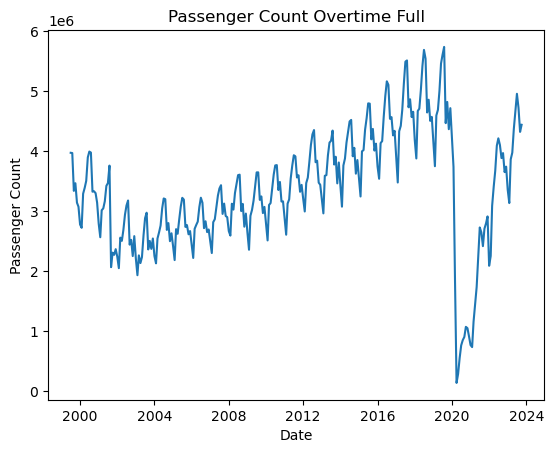

In [5]:
ax = sns.lineplot(
    data=df,
    x='date',
    y='passenger_count'
)
ax.set(
    title="Passenger Count Overtime Full",
    xlabel="Date",
    ylabel="Passenger Count"
)
plt.show()

Explanation
1. We can see right away the impact of Covid 19 Pandemic in 2020
2. We will split Pre and Post Covid 19 Pandemic

## Line Plot Pre Covid 19 and Post Covid 19

In [6]:
break_point = '2020-01-01'
df_pre_covid = df[df['date']<break_point]
df_post_covid = df[df['date']>=break_point]

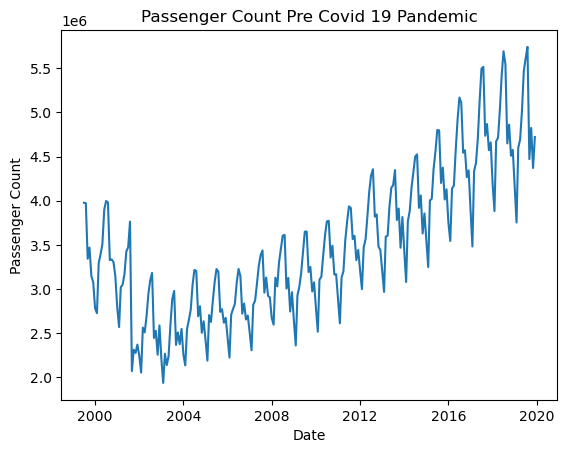

In [7]:
ax = sns.lineplot(
    data=df_pre_covid,
    x='date',
    y='passenger_count'
)
ax.set(
    title="Passenger Count Pre Covid 19 Pandemic",
    xlabel="Date",
    ylabel="Passenger Count"
)
plt.show()

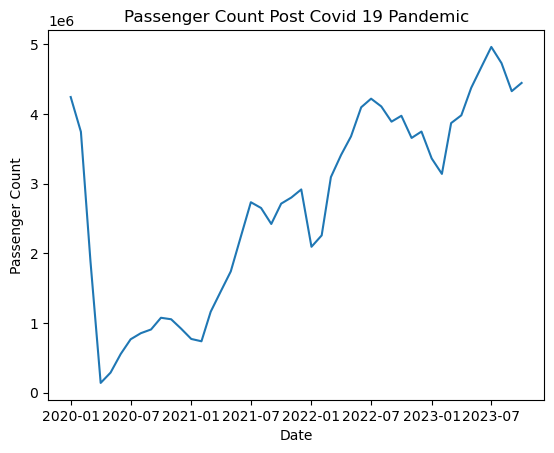

In [8]:
ax = sns.lineplot(
    data=df_post_covid,
    x='date',
    y='passenger_count'
)
ax.set(
    title="Passenger Count Post Covid 19 Pandemic",
    xlabel="Date",
    ylabel="Passenger Count"
)
plt.show()

## Check for Yearly Seasonality

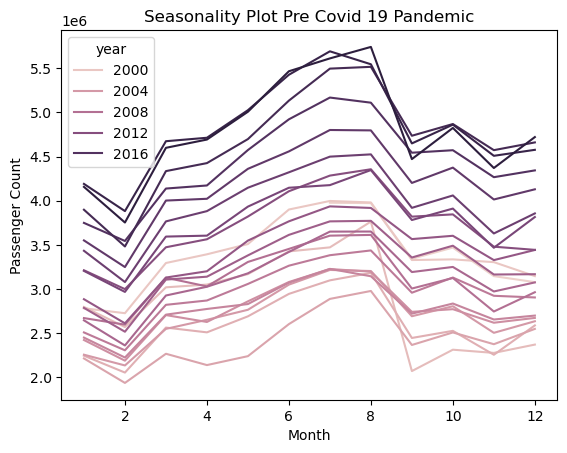

In [9]:
ax = sns.lineplot(
    data=df_pre_covid,
    x='month',
    y='passenger_count',
    hue='year',
)
ax.set(
    title='Seasonality Plot Pre Covid 19 Pandemic',
    xlabel='Month',
    ylabel='Passenger Count'
)
plt.show()

Explanation:
1. Yearly seasonality inside the data

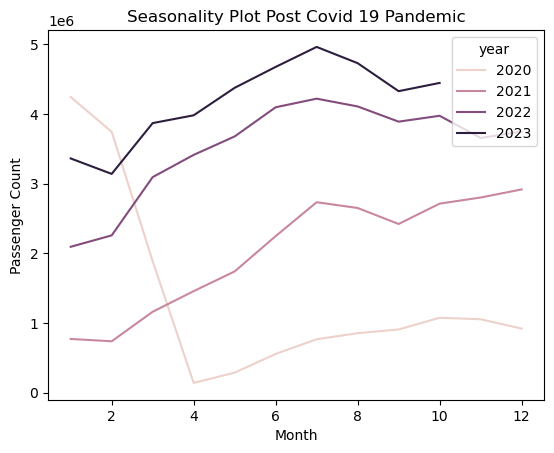

In [10]:
ax = sns.lineplot(
    data=df_post_covid,
    x='month',
    y='passenger_count',
    hue='year',
)
ax.set(
    title='Seasonality Plot Post Covid 19 Pandemic',
    xlabel='Month',
    ylabel='Passenger Count'
)
plt.show()

Explanation:
1. Yearly seasonality inside the data

## Sub Series Seasonal Plots

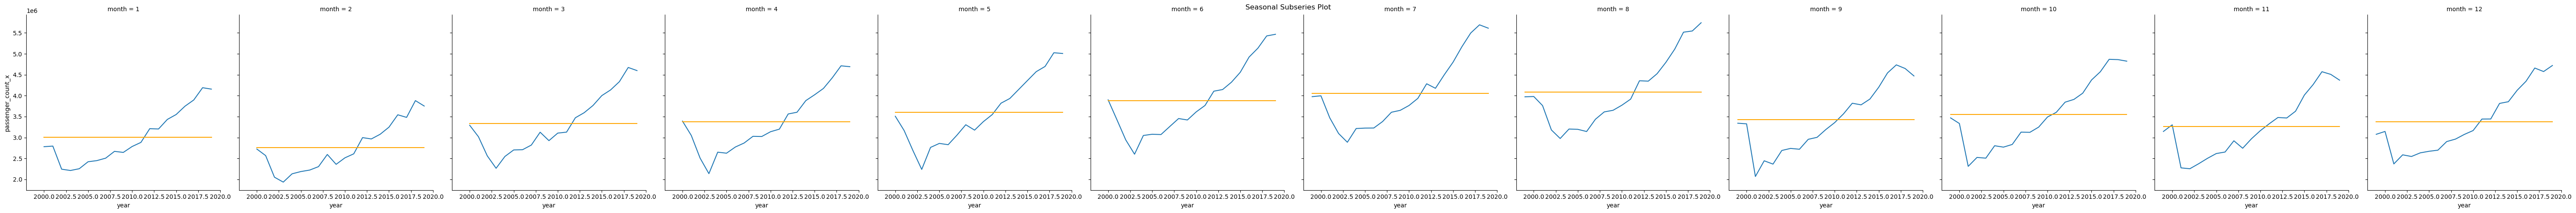

In [11]:
mean_by_month = df_pre_covid.groupby(by='month').agg({'passenger_count': 'mean'})
plot_df_pre_covid = df_pre_covid.merge(mean_by_month, on='month', how='left')
fg = sns.relplot(
    data=plot_df_pre_covid,
    x='year',
    y='passenger_count_x',
    col='month',
    kind='line'
)

for i, ax in enumerate(fg.axes.flat):
    sns.lineplot(data=plot_df_pre_covid[plot_df_pre_covid['month']==i+1], x='year', y='passenger_count_y', color='orange', ax=ax)

fg.figure.suptitle("Seasonal Subseries Plot")
plt.show()

Explanation
1. Between 2001 - 2022, there's a short decline which leads to uptrend on the amount of passengers until early 2020. 
2. There's a pattern exist based on the mean (orange horizontal line). It starts from the January and it increased until August. Then it decreased again.  
3. We can see that there's a yearly seasonality inside the data

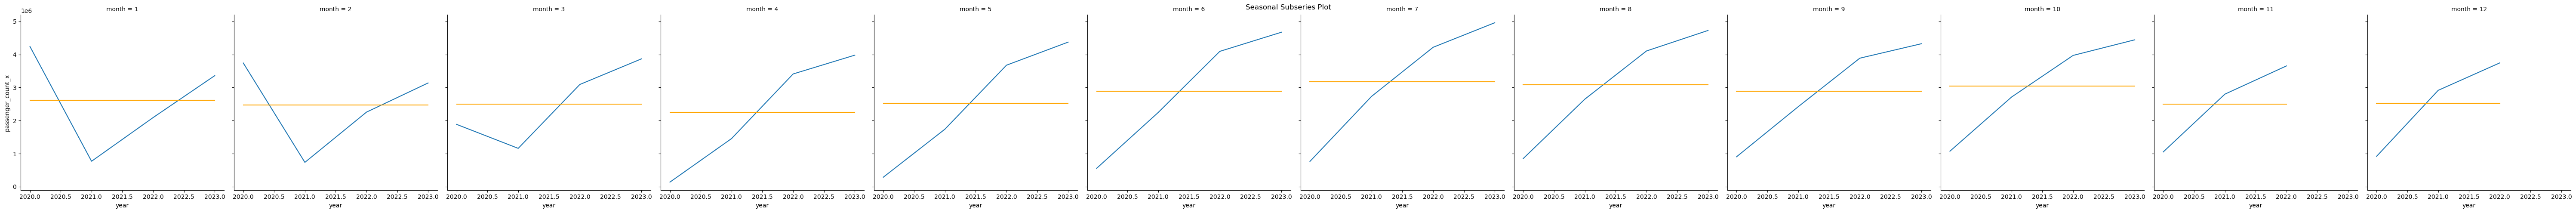

In [12]:
mean_by_month = df_post_covid.groupby(by='month').agg({'passenger_count': 'mean'})
plot_df_post_covid = df_post_covid.merge(mean_by_month, on='month', how='left')
fg = sns.relplot(
    data=plot_df_post_covid,
    x='year',
    y='passenger_count_x',
    col='month',
    kind='line'
)

for i, ax in enumerate(fg.axes.flat):
    sns.lineplot(data=plot_df_post_covid[plot_df_post_covid['month']==i+1], x='year', y='passenger_count_y', color='orange', ax=ax)

fg.figure.suptitle("Seasonal Subseries Plot")
plt.show()

Explanation
1. Same view that there's a strong uptrend inside the post covid data.
2. There's a pattern exist based on the mean (orange horizontal line). It starts from the January and it increased until August. Then it stabled until October before it decreased again.  

## Autocorrelation & Partial Autocorrelation Plot

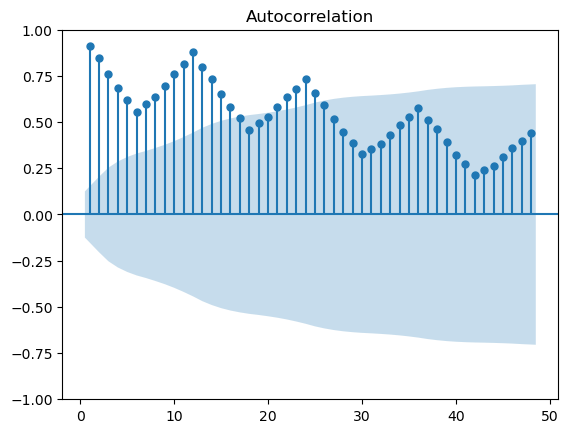

In [13]:
plot_acf(df_pre_covid['passenger_count'], zero=False, lags=48)
plt.show()

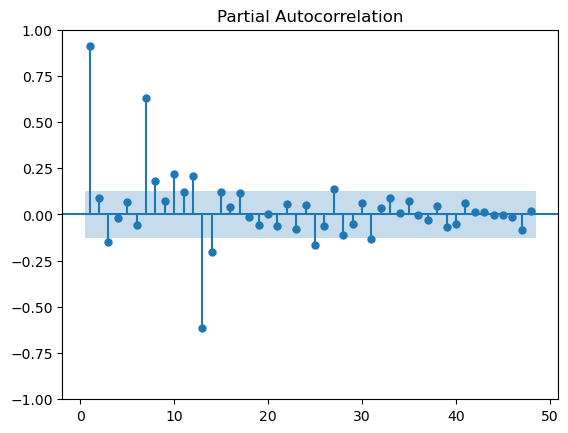

In [14]:
plot_pacf(df_pre_covid['passenger_count'], zero=False, lags=48)
plt.show()

Explanation:
1. We can see a repeating pattern at multiples of 12
2. Indication of using seasonal model

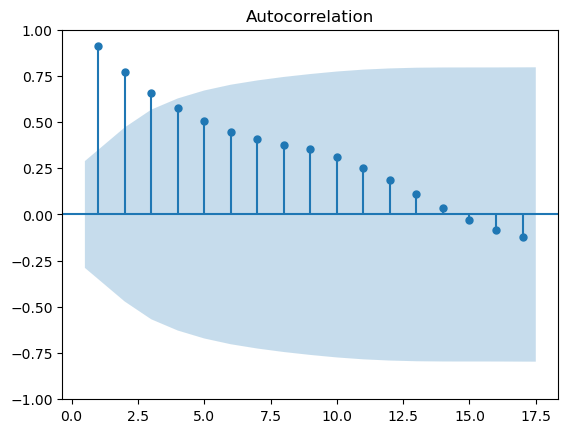

In [15]:
plot_acf(df_post_covid['passenger_count'], zero=False)
plt.show()

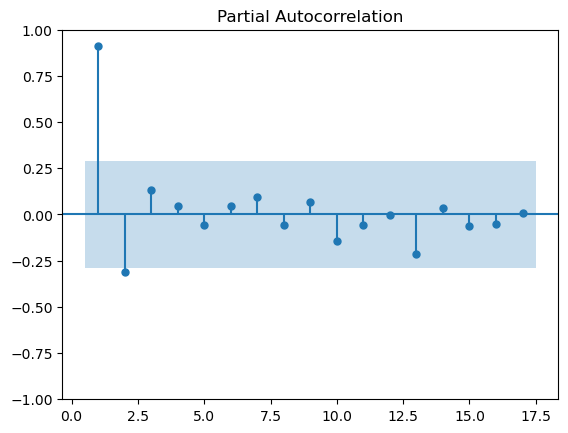

In [16]:
plot_pacf(df_post_covid['passenger_count'], zero=False)
plt.show()

Explanation:
1. The future value is dependent on previous time step. We can see that there's a spike of inside PACF in the 1st and 2nd lag. 
2. Indication of using Auto Regressive (AR) Model because the ACF tails, also we will using the 1st and 2nd lag as the `p` in AR Model.